# **0. PREPARATION AND LIBRARIES**

In [1]:
!pip install opendatasets

In [2]:
! pip install ultralytics

In [3]:
import os

In [4]:
import random
import opendatasets as od
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from ultralytics import YOLO
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# drive.mount('/content/drive')

In [6]:
# move to preferred working directory

# %cd "/content/drive/MyDrive/REA Projects/Object Detection/Playing Card Detection"

In [7]:
# set working directory

HOME = os.getcwd()
print(HOME)

/kaggle/working


# **1. DOWNLOAD DATASET**

In [8]:
# download dataset with opendatasets from Kaggle

od.download("https://www.kaggle.com/datasets/andy8744/playing-cards-object-detection-dataset")

Skipping, found downloaded files in "./playing-cards-object-detection-dataset" (use force=True to force download)


In [9]:
# define train, valid, test directories


train_images = os.path.join(HOME, "playing-cards-object-detection-dataset/train/images")
train_labels = os.path.join(HOME, "playing-cards-object-detection-dataset/train/labels")

valid_images = os.path.join(HOME, "playing-cards-object-detection-dataset/valid/images")
valid_labels = os.path.join(HOME, "playing-cards-object-detection-dataset/valid/labels")

test_images = os.path.join(HOME, "playing-cards-object-detection-dataset/test/images")
test_labels = os.path.join(HOME, "playing-cards-object-detection-dataset/test/labels")

yaml_path = os.path.join(HOME, "playing-cards-object-detection-dataset/data.yaml")

In [10]:
print(train_images)
print(valid_images)
print(test_images)


/kaggle/working/playing-cards-object-detection-dataset/train/images
/kaggle/working/playing-cards-object-detection-dataset/valid/images
/kaggle/working/playing-cards-object-detection-dataset/test/images


In [11]:
yaml_path

'/kaggle/working/playing-cards-object-detection-dataset/data.yaml'

In [12]:
# Configure YAML

# %writefile "$yaml_path"

# train: /kaggle/working/playing-cards-object-detection-dataset/train/images
# val: /kaggle/working/playing-cards-object-detection-dataset/val/images
# test: /kaggle/working/playing-cards-object-detection-dataset/test/images

# nc: 52
# names: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']

In [13]:
# Define the YAML content as a string
yaml_content = """
train: /kaggle/working/playing-cards-object-detection-dataset/train/images
val: /kaggle/working/playing-cards-object-detection-dataset/valid/images
test: /kaggle/working/playing-cards-object-detection-dataset/test/images

nc: 52
names: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
"""

# Write the YAML content to a file
with open(yaml_path, 'w') as file:
    file.write(yaml_content)

In [14]:
# Define the labels

classes = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']

Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}

print('Index to Label Mapping:', Idx2Label)
print('Label to Index Mapping:', Label2Index)

Index to Label Mapping: {0: '10c', 1: '10d', 2: '10h', 3: '10s', 4: '2c', 5: '2d', 6: '2h', 7: '2s', 8: '3c', 9: '3d', 10: '3h', 11: '3s', 12: '4c', 13: '4d', 14: '4h', 15: '4s', 16: '5c', 17: '5d', 18: '5h', 19: '5s', 20: '6c', 21: '6d', 22: '6h', 23: '6s', 24: '7c', 25: '7d', 26: '7h', 27: '7s', 28: '8c', 29: '8d', 30: '8h', 31: '8s', 32: '9c', 33: '9d', 34: '9h', 35: '9s', 36: 'Ac', 37: 'Ad', 38: 'Ah', 39: 'As', 40: 'Jc', 41: 'Jd', 42: 'Jh', 43: 'Js', 44: 'Kc', 45: 'Kd', 46: 'Kh', 47: 'Ks', 48: 'Qc', 49: 'Qd', 50: 'Qh', 51: 'Qs'}
Label to Index Mapping: {'10c': 0, '10d': 1, '10h': 2, '10s': 3, '2c': 4, '2d': 5, '2h': 6, '2s': 7, '3c': 8, '3d': 9, '3h': 10, '3s': 11, '4c': 12, '4d': 13, '4h': 14, '4s': 15, '5c': 16, '5d': 17, '5h': 18, '5s': 19, '6c': 20, '6d': 21, '6h': 22, '6s': 23, '7c': 24, '7d': 25, '7h': 26, '7s': 27, '8c': 28, '8d': 29, '8h': 30, '8s': 31, '9c': 32, '9d': 33, '9h': 34, '9s': 35, 'Ac': 36, 'Ad': 37, 'Ah': 38, 'As': 39, 'Jc': 40, 'Jd': 41, 'Jh': 42, 'Js': 43, 'K

# **2. EXPLORE DATASET**

In [15]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 10 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

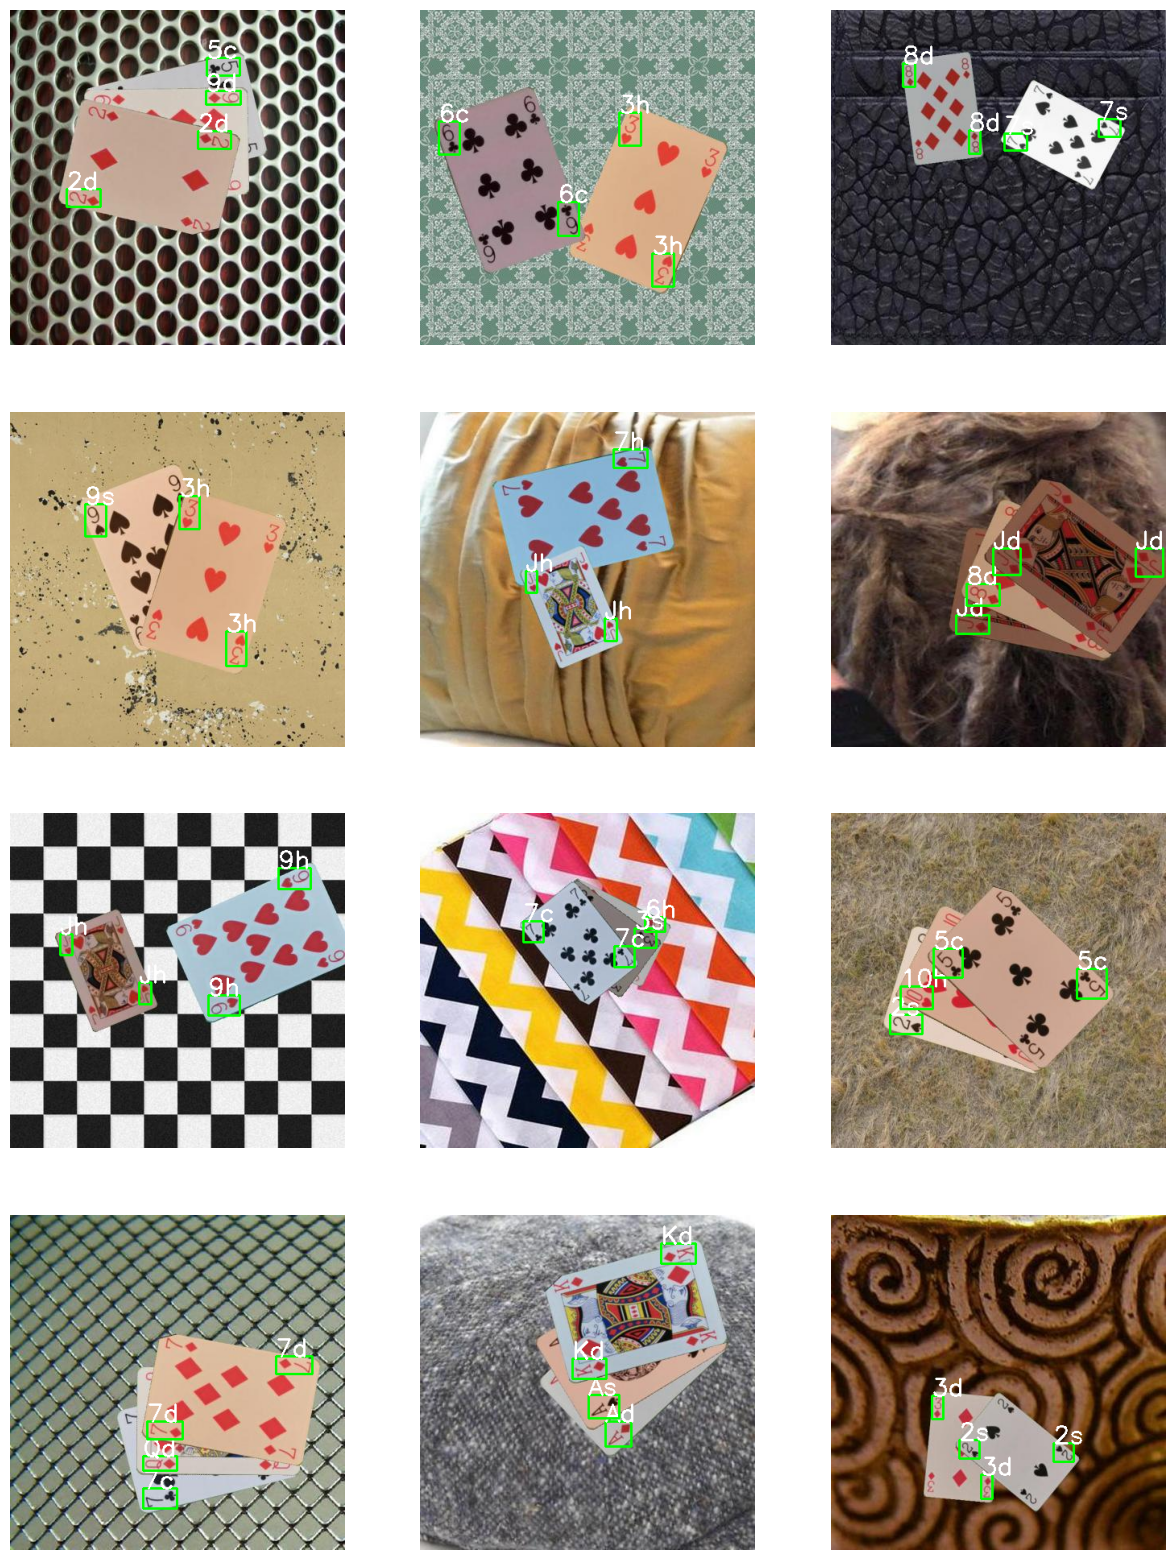

In [16]:
# Visualize 6 sample images with bounding boxes

visualize_image_with_annotation_bboxes(train_images, train_labels)

In [17]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[-1])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 416x416 and 3 channels


# **3. TRAINING**

In [19]:
# Load a pretrained nano model
model = YOLO('yolov8n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
results = model.train(
    data= yaml_path,
    epochs = 25,
    imgsz = (height, width, channels),
    seed = 42,
    batch = 8,
    workers = 4,
    patience = 5,
    name = 'yolov8n_custom')

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/playing-cards-object-detection-dataset/data.yaml, epochs=25, patience=5, batch=8, imgsz=(416, 416, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_custom3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

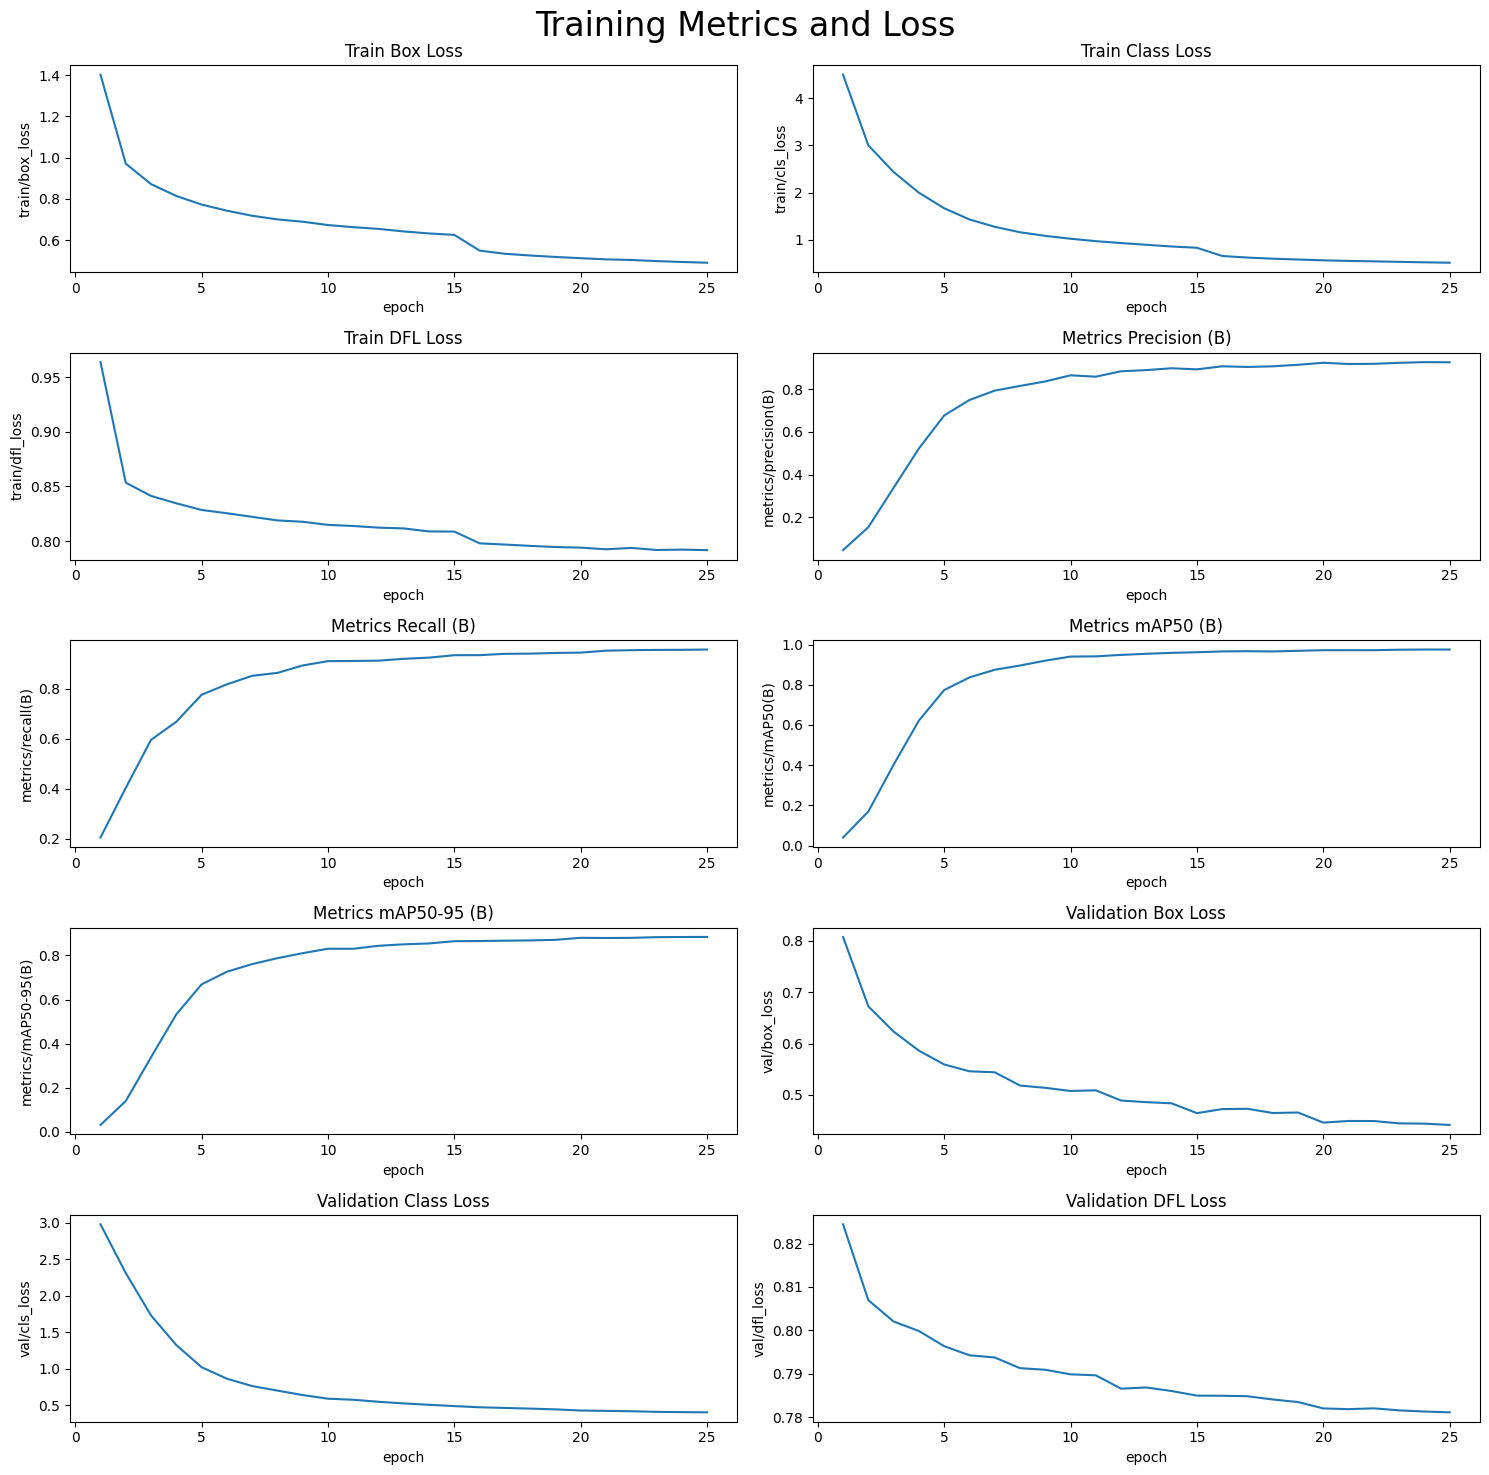

In [20]:
# plot the result

%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_custom3/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# **4. EVALUATION**

In [21]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_custom3/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 168 layers, 3015788 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /kaggle/working/playing-cards-object-detection-dataset/test/labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:01<00:00, 1171.06it/s]
val: New cache created: /kaggle/working/playing-cards-object-detection-dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:12<00:00,  9.70it/s]
                   all       2000       7588      0.927      0.955      0.975      0.899
                   10c       2000        137      0.854      0.927      0.964      0.853
                   10d       2000        170      0.922      0.976      0.988      0.878
                   10h       2000        149      0.919      0.917      0.976      0.858
                   10s       2000        151      0.907  

In [23]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.8992678242498661
Mean Average Precision @ .50   : 0.974932745256321
Mean Average Precision @ .70   : 0.9736903216992832


# **5. PREDICTION**

In [24]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Pass the image through the detection model and get the result
    detect_result = model(image)

    # Plot the detections
    detect_image = detect_result[0].plot()

    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image


0: 416x416 2 7cs, 2 Kds, 6.9ms
Speed: 3.4ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 9ss, 4 Ahs, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 2.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 10s, 1 4h, 2 4ss, 5.7ms
Speed: 1.2ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 8ss, 1 Ac, 1 Kh, 6.1ms
Speed: 1.1ms preprocess, 6.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 10cs, 2 Kcs, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 3ds, 3 8hs, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 4cs, 3 7ds, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 3 Ass, 2 Kcs, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.5ms postproces

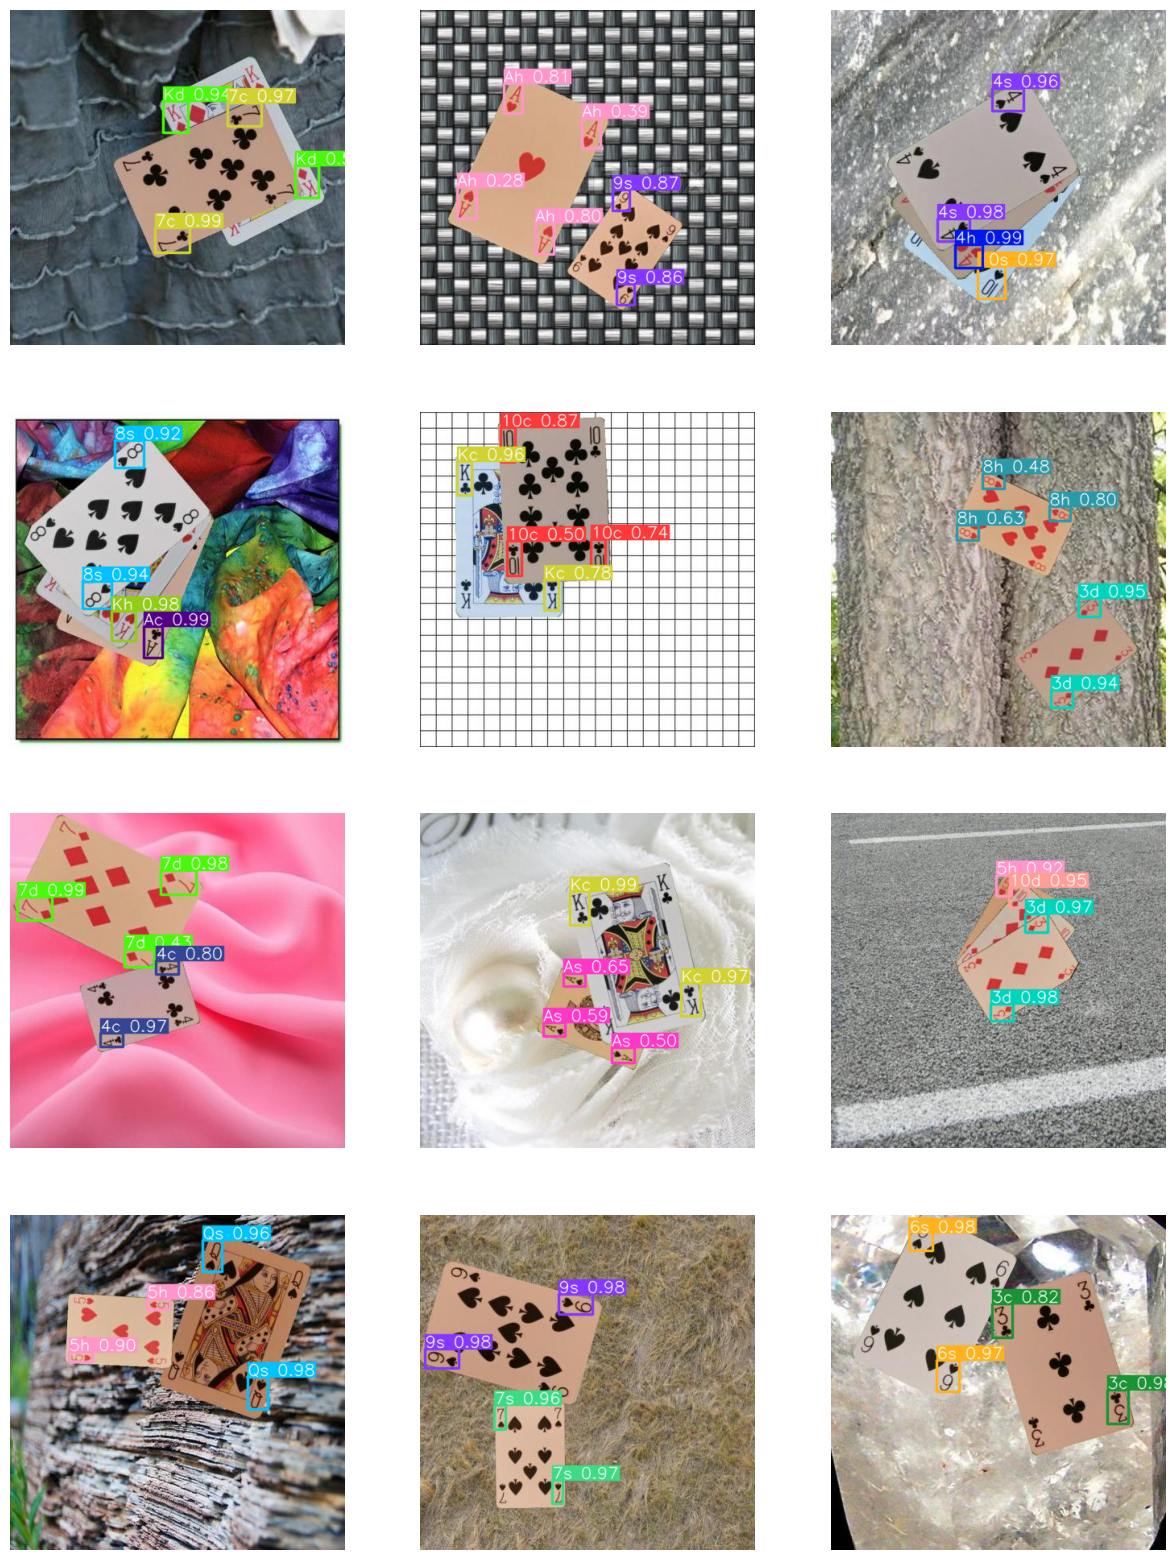

In [25]:
# Get list of all the image files in the test directory
image_files = sorted(os.listdir(test_images))

# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3

    # Load the current image and run object detection
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)

    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()